# Parallel Beam Tomographic Reconstruction using Simple Backprojection


In [75]:
import numpy as np
from scipy.interpolate import interp1d
from functools import partial
import pydicom as dicom
from skimage.transform import radon
import matplotlib.pyplot as plt

from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

In [76]:
def simple_backprojection(radon_transform, theta=None, output_size=256, interpolation="linear"):
    # radon_transform: pass as input, the radon transform of the desired image, it has the shape (number of detectors, number of projections)
    # theta: Number of projections taken while obtaining the radon transform, for instance, if 984 projections are taken while covering an angle from 0 to 2pi, theta will be: np.linspace(0, 360, 984, endpoint=False)

    if theta is None:
        theta = np.linspace(0, 180, radon_transform.shape[1], endpoint=False)

    # store number of projections in the variable: angles_count
    # HERE
    angles_count =len(theta)

    if angles_count != radon_transform.shape[1]:
        raise ValueError("The given 'theta' vector does not match the number of projections in the radon transform")

    interpolation_types = ["linear", "nearest", "cubic"]
    
    if interpolation not in interpolation_types:
        raise ValueError("Interpolation type not supported, please choose one of the following: {}".format(interpolation_types))

    # convert radon_image to np.float32
    # HERE
    radon_transform = radon_transform.astype(np.float32)

    #######################################################
    dtype = radon_transform.dtype

    img_shape = radon_transform.shape[0]

    if output_size is None:
        # If output size not specified, estimate from input radon image
        output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))
    #######################################################

    # Reconstruct image by interpolation
    # create a variable reconstructed of size output_size x output_size with the same dtype as the radon_transform and initialize all values in it to zero
    # HERE
    reconstructed = np.zeros((output_size, output_size), dtype=dtype)

    ##### Here we create a grid, your job is to backproject the radon transform on this grid #####
    radius = output_size // 2
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    ### Backprojection ###
    # each column in the radon transform represents a projection along a given angle theta
    # the number of rays in each such projection is equal to the number of detectors (first dimension of radon_transform)
    # for each projection, you have the ray sum along each detector -> 1 point in the radon transform,
    # you have to backproject this point on a cartesian grid so we can see the reconstructed image

    # the grid has been made for you, it is stored in the variables xpr and ypr
    # representing the x and y coordinates of each point in the grid

    # iterate over each column in the radon transform and backproject it on the grid
    # use interpolation to obtain values corresponding to EXACT points on the grid
    # HERE

    for col, angle in zip(radon_transform.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        if interpolation == "linear":
            interpolant  = partial(np.interp, xp=x, fp=col, left=0, right=0)
        else:
            interpolant = interp1d(x, col, kind=interpolation,bounds_error=False, fill_value=0)
        
        reconstructed += interpolant(t)
            

    return reconstructed * np.pi / (2 * angles_count)

In [77]:
## load the input and store in a variable named inp
inp = dicom.dcmread('../data/ct_covid_lung/CT-7358-0014.dcm')
# print(inp)

In [78]:
## load the radon transform of the input and store in a variable named radon_transform
# HERE
radon_transform = radon(inp.pixel_array)
print(radon_transform.shape)

/home/hardk/.local/lib/python3.11/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


(512, 180)


In [79]:
# # call the function simple_backprojection with the appropriate parameters and store the output in a variable named out
# # HERE
out = simple_backprojection(radon_transform, output_size=None)

In [80]:
# #### This is just for visualization and scoring, you don't have to do anything here ####
# # normalize both
inp = inp.pixel_array.astype(np.float32)
inp = (inp - inp.min()) / (inp.max() - inp.min())
out = (out - out.min()) / (out.max() - out.min())

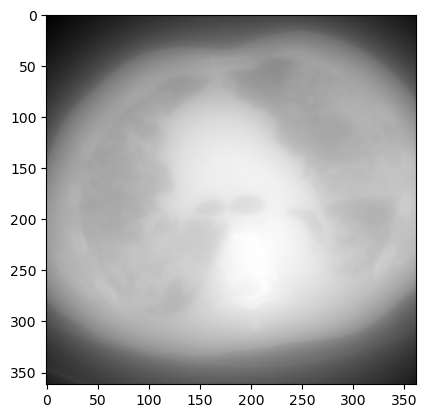

In [81]:
plt.imshow(out, cmap='gray')
plt.show()


In [82]:
print(f"MSE: {mean_squared_error(inp, out)}")
print(f"PSNR: {peak_signal_noise_ratio(inp, out)}")

ValueError: Input images must have the same dimensions.

In [83]:
print(inp.shape)
print(out.shape)

(512, 512)
(362, 362)
